In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.autonotebook import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt

import utils as ut

plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

%load_ext autoreload
%autoreload 2

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_27817/198242598.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Load data

In [2]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

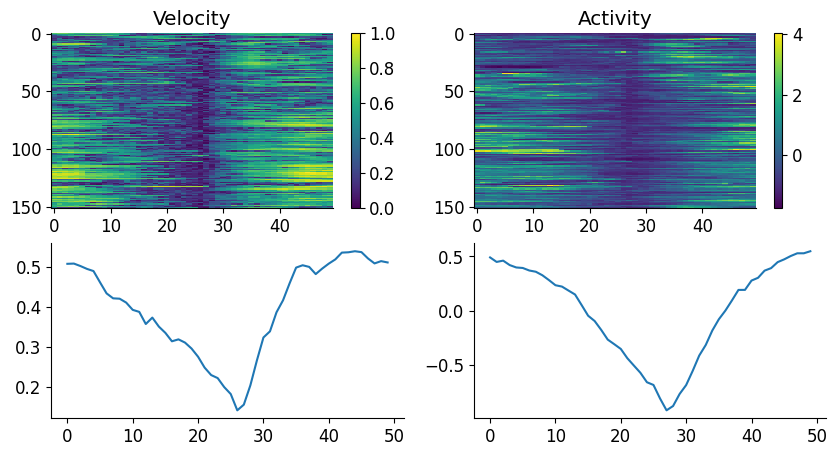

In [3]:
animal = 'animal_2'
cell = 'cell_2'

velocity = factors_dict[animal]['Velocity'].T
activity = activity_dict[animal][cell].T
# activity = (activity - activity.min()) / (activity.max() - activity.min())

fig, ax = plt.subplots(2,2, figsize=(10,5))
im = ax[0,0].imshow(velocity, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
im = ax[0,1].imshow(activity, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Activity')
ax[1,0].plot(velocity.mean(axis=0))
ax[1,1].plot(activity.mean(axis=0))

In [4]:
# Train GLM for comparison
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity_dict[animal][cell], regression='linear')


## 2. Preprocess data into time series batches suitable for LSTM

In [ ]:
seq_length = 5

# velocity_flattened = velocity.flatten()
# activity_flattened = activity.flatten()
# X, y = create_RNN_data_sequences(velocity_flattened, activity_flattened, seq_length, split='continuous')

X, y = ut.create_RNN_data_sequences(velocity, activity, seq_length, split='trial')
print(X.shape, y.shape)  # (num_samples, seq_length), (num_samples,)

torch.Size([6840, 5]) torch.Size([6840])


In [6]:
# train_ratio, val_ratio = 0.9, 0.1  # 90% train, 10% val, 0% test
# train_size = int(len(X) * train_ratio)
# val_size = int(len(X) * val_ratio)
# # test_size = len(X) - train_size - val_size  # Remainder for test set

# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
# X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=True, random_state=42)

# Unsqueeze to add the "input_size" dimension (last dimension)
X_train = X_train.unsqueeze(-1) 
X_val = X_val.unsqueeze(-1)
# X_test = X_test.unsqueeze(-1)
y_train = y_train.unsqueeze(-1)
y_val = y_val.unsqueeze(-1)
# y_test = y_test.unsqueeze(-1)
print(X_train.shape, X_val.shape)  # Shape: (num_train, seq_length, 1)


torch.Size([6498, 5, 1]) torch.Size([342, 5, 1])


In [7]:
batch_size = 32
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=1, shuffle=False)

## 3. Train RNN/LSTM/GRU model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 200
learning_rate = 0.005

hidden_size = 128
num_layers = 2
# model = VelocityLSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
# model = VelocityGRU(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
model = VelocityRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


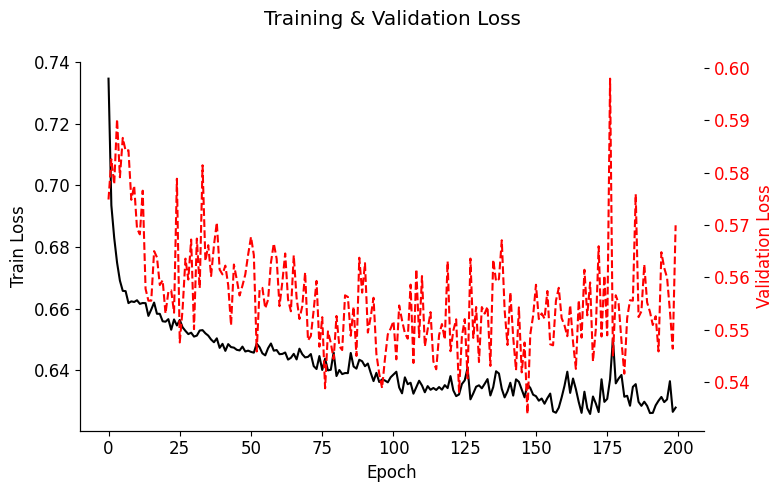

In [9]:
train_losses = []
val_losses = []
best_val_loss = float("inf")  # Initialize with a high value
best_model_state_dict = None

for epoch in tqdm(range(num_epochs)): 
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        # if clip_grads:
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop (no gradient updates)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            loss = criterion(y_val_pred, y_val_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # # Save best model based on validation loss
    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     best_model_state_dict = model.state_dict()
    #     print(f"Epoch {epoch+1}: New best model saved with val loss {best_val_loss:.6f}")

    # print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

last_model_state_dict = model.state_dict()
# save the model
torch.save(last_model_state_dict, "velocity_correction_LSTM_model.pth")


# Plot Training & Validation Loss with Dual Y-Axis
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss", color="k")
ax1.plot(train_losses, label="Train Loss", color="k")
ax1.tick_params(axis="y", labelcolor="k")
ax2 = ax1.twinx()  # Create a second y-axis
ax2.set_ylabel("Validation Loss", color="red")
ax2.plot(val_losses, label="Validation Loss", color="red", linestyle="dashed")
ax2.tick_params(axis="y", labelcolor="red")
fig.suptitle("Training & Validation Loss")
fig.tight_layout()
plt.show()

In [10]:
# Load the best model before testing
# model.load_state_dict(best_model_state_dict)
# model.load_state_dict(last_model_state_dict)
# model.eval()
model.load_state_dict(torch.load("velocity_correction_LSTM_model.pth"))

full_dataset = DataLoader(TensorDataset(X, y), batch_size=1, shuffle=False)
all_predictions = []
with torch.no_grad():
    for X_sample, y_sample in full_dataset:
        X_sample, y_sample = X_sample.to(device), y_sample.to(device)
        y_pred = model(X_sample.unsqueeze(-1))
        all_predictions.append(y_pred.cpu().numpy())
all_predictions = np.concatenate(all_predictions)

# padding = np.full((seq_length,1), np.nan)
# all_predictions = np.concatenate([padding,all_predictions]) # Pad with zeros to match the original dataset length (since first y point starts at seq_length)
# pred = all_predictions.reshape(activity.shape)

pred = all_predictions.reshape(activity.shape[0],activity.shape[1]-seq_length)
padding = np.full((activity.shape[0],seq_length),np.nan)
pred = np.concatenate((padding,pred),axis=1)

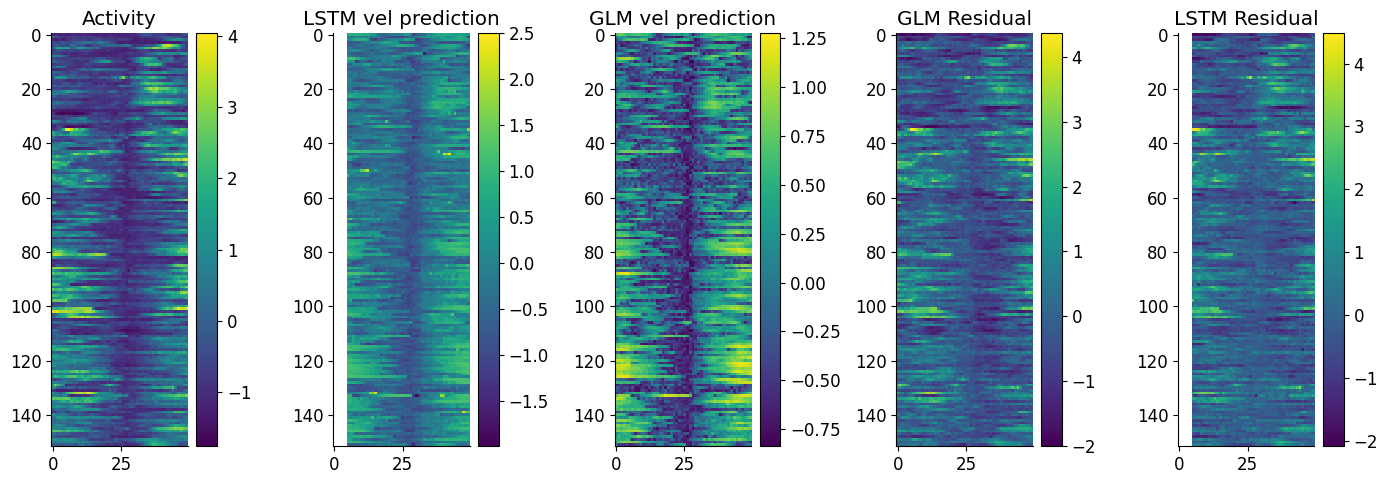

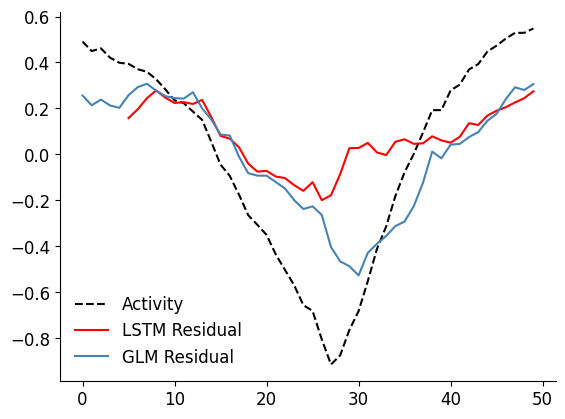

In [12]:
num_trials = activity.shape[0]

fig, ax = plt.subplots(1, 5, figsize=(14, 5))
im = ax[0].imshow(activity, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Activity')
im = ax[1].imshow(pred, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('LSTM vel prediction')

glm_prediction = neuron_predicted_activity.reshape(-1,num_trials).T
im = ax[2].imshow(glm_prediction, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[2])
ax[2].set_title('GLM vel prediction')

glm_residual = activity-glm_prediction  
im = ax[3].imshow(glm_residual, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[3])
ax[3].set_title('GLM Residual')

LSTM_residual = activity-pred
im = ax[4].imshow(LSTM_residual, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[4])
ax[4].set_title('LSTM Residual')
fig.tight_layout()
plt.show()

plt.plot(np.mean(activity, axis=0), color='k', linestyle='--', label='Activity')
plt.plot(np.mean(LSTM_residual, axis=0), color='red', label='LSTM Residual')
plt.plot(np.mean(glm_residual, axis=0), color='steelblue', label='GLM Residual')
plt.legend()
plt.show()

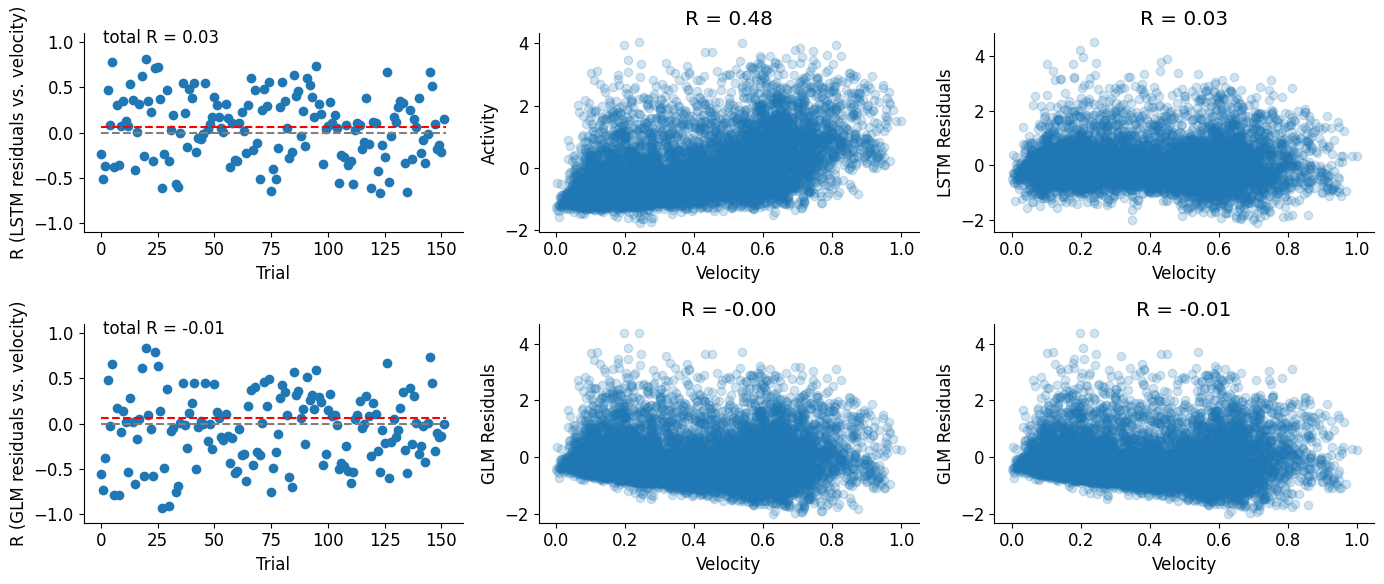

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

R_values_lstm = []
R_values_glm = []
for trial in range(num_trials):
    R_values_lstm.append(np.corrcoef(LSTM_residual[trial][seq_length:], velocity[trial][seq_length:])[0, 1])
    R_values_glm.append(np.corrcoef(glm_residual[trial][seq_length:], velocity[trial][seq_length:])[0, 1])
ax[0, 0].scatter(np.arange(num_trials), R_values_lstm)
ax[0, 0].hlines(0, 0, num_trials, linestyles='dashed', color='gray')
ax[0, 0].hlines(np.mean(R_values_lstm), 0, num_trials, linestyles='dashed', color='red')
ax[0, 0].set_ylim(-1.1, 1.1)
ax[0, 0].set_xlabel('Trial')
ax[0, 0].set_ylabel('R (LSTM residuals vs. velocity)')
overall_R = np.corrcoef(velocity[:, seq_length:].flatten(), LSTM_residual[:, seq_length:].flatten())[0, 1]
ax[0, 0].text(0.05, 0.95, f'total R = {np.mean(overall_R):.2f}', transform=ax[0, 0].transAxes)

# # Color points based on time/trial
# for trial in range(num_trials):
#     ax[0, 1].scatter(velocity[trial, :], activity[trial, :], color=plt.cm.jet(trial / num_trials), alpha=0.2)
ax[0, 1].scatter(velocity.flatten(), activity.flatten(), alpha=0.2)
correlation_R = np.corrcoef(velocity.flatten(), activity.flatten())[0, 1]
ax[0, 1].set_title(f'R = {correlation_R:.2f}')
ax[0, 1].set_xlabel('Velocity')
ax[0, 1].set_ylabel('Activity')

ax[0, 2].scatter(velocity[:, seq_length:].flatten(), LSTM_residual[:, seq_length:].flatten(), alpha=0.2)
correlation_R = np.corrcoef(velocity[:, seq_length:].flatten(), LSTM_residual[:, seq_length:].flatten())[0, 1]
ax[0, 2].set_title(f'R = {correlation_R:.2f}')
ax[0, 2].set_xlabel('Velocity')
ax[0, 2].set_ylabel('LSTM Residuals')


ax[1, 0].scatter(np.arange(num_trials), R_values_glm)
ax[1, 0].hlines(0, 0, num_trials, linestyles='dashed', color='gray')
ax[1, 0].hlines(np.mean(R_values_lstm), 0, num_trials, linestyles='dashed', color='red')
ax[1, 0].set_ylim(-1.1, 1.1)
ax[1, 0].set_xlabel('Trial')
ax[1, 0].set_ylabel('R (GLM residuals vs. velocity)')
overall_R = np.corrcoef(velocity[:, seq_length:].flatten(), glm_residual[:, seq_length:].flatten())[0, 1]
ax[1, 0].text(0.05, 0.95, f'total R = {np.mean(overall_R):.2f}', transform=ax[1, 0].transAxes)

ax[1, 1].scatter(velocity.flatten(), glm_residual.flatten(), alpha=0.2)
correlation_R = np.corrcoef(velocity.flatten(), glm_residual.flatten())[0, 1]
ax[1, 1].set_title(f'R = {correlation_R:.2f}')
ax[1, 1].set_xlabel('Velocity')
ax[1, 1].set_ylabel('GLM Residuals')

ax[1, 2].scatter(velocity[:, seq_length:].flatten(), glm_residual[:, seq_length:].flatten(), alpha=0.2)
correlation_R = np.corrcoef(velocity[:, seq_length:].flatten(), glm_residual[:, seq_length:].flatten())[0, 1]
ax[1, 2].set_title(f'R = {correlation_R:.2f}')
ax[1, 2].set_xlabel('Velocity')
ax[1, 2].set_ylabel('GLM Residuals')

plt.tight_layout()
plt.show()
